Bibliotecas

In [ ]:
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from operator import itemgetter
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# TensorFlow/Keras imports
import tensorflow as tf
from tensorflow.keras import models, layers, optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, Flatten

# Set seaborn style
sns.set()

Exploração de Dados

In [ ]:
df = pd.read_csv("https://raw.githubusercontent.com/adriel1ft/stock-prediction-cnn/main/Netflix.csv", index_col = 0)

"""
netflix já tem a coluna adj close
df["adj close"] = df.close # Moving close to the last column
df.drop(labels=['close'], axis=1, inplace=True) # Moving close to the last column
"""

df.rename(columns={'Open': 'open', 'High': 'high', 'Low':'low', 'Close': 'close', 'Adj Close': 'adj close', 'Volume':'volume'}, inplace=True)
df.drop(labels=['close'], axis=1, inplace=True)

df['volume'] = df['volume'].astype(float)

df.head()

,open,high,low,adj close,volume
Date,,,,,
2015-01-02,49.151428,50.331429,48.731430,49.848572,13475000.0
2015-01-05,49.258572,49.258572,47.147144,47.311428,18165000.0
2015-01-06,47.347141,47.639999,45.661430,46.501431,16037700.0
2015-01-07,47.347141,47.421429,46.271427,46.742859,9849700.0
2015-01-08,47.119999,47.835712,46.478573,47.779999,9601900.0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1761 entries, 2015-01-02 to 2021-12-29
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   open       1761 non-null   float64
 1   high       1761 non-null   float64
 2   low        1761 non-null   float64
 3   adj close  1761 non-null   float64
 4   volume     1761 non-null   float64
dtypes: float64(5)
memory usage: 82.5+ KB


<ipython-input-4-086d69e1303a>:2: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(411)


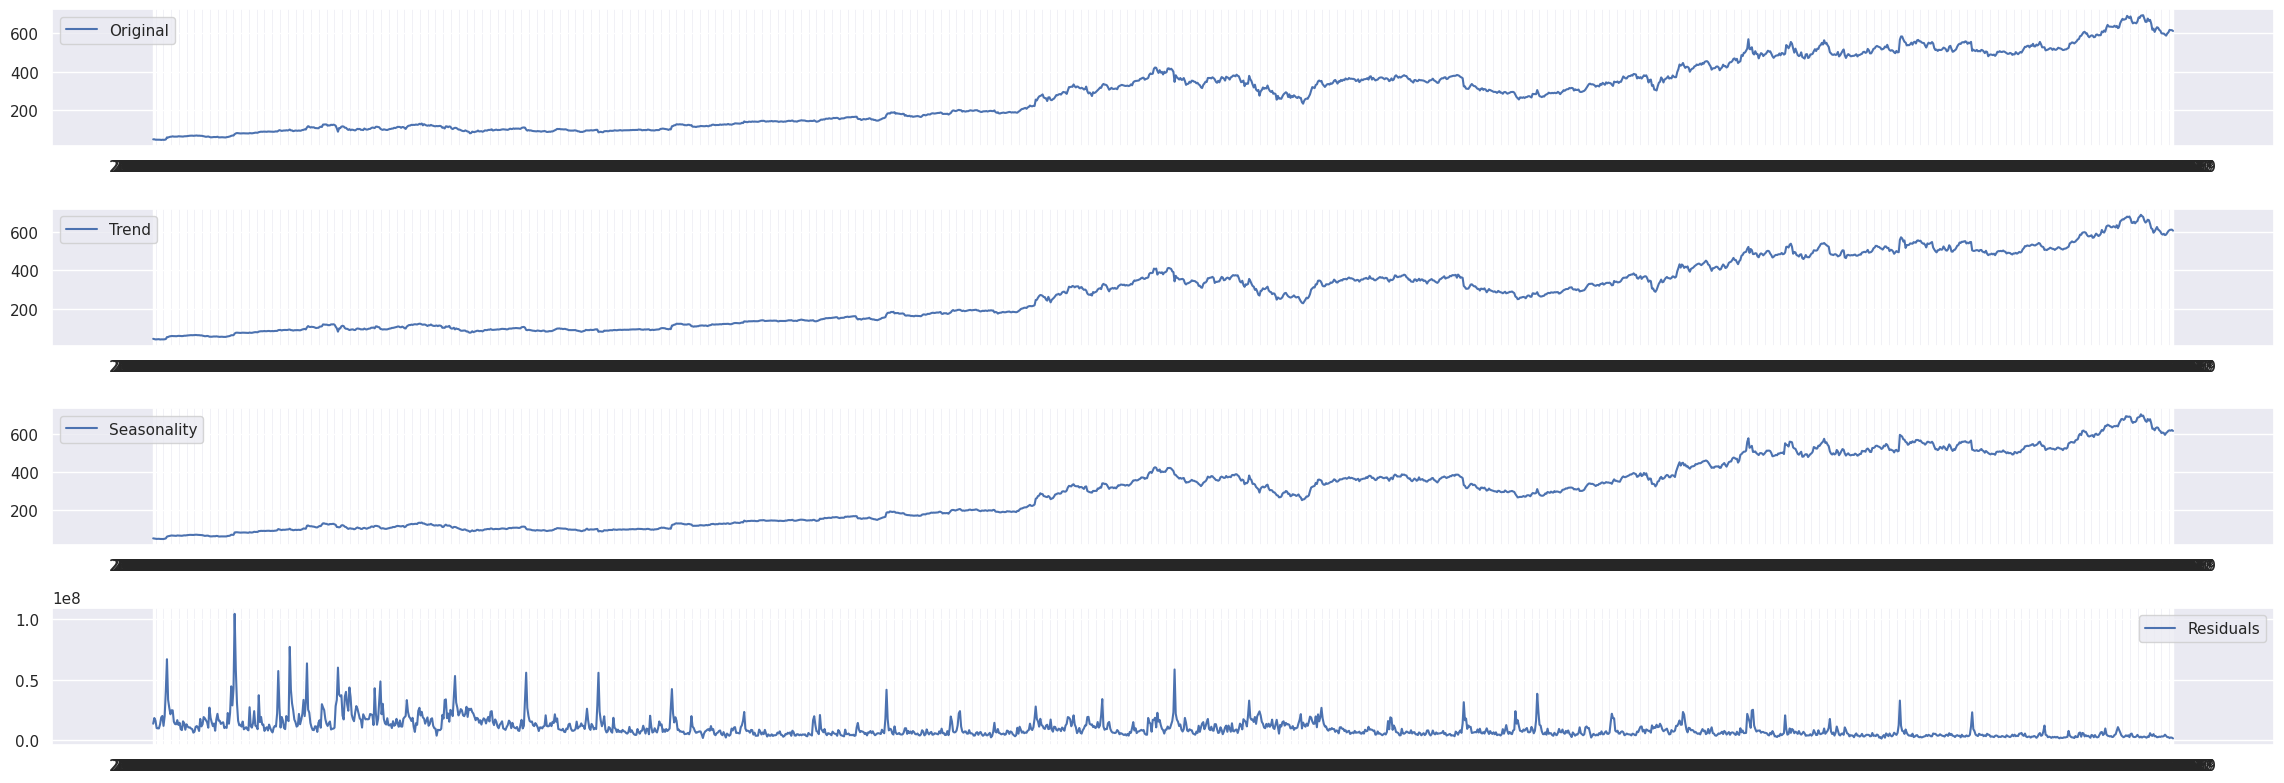

In [ ]:
df.plot(figsize=(23,8),title = "Netflix Stock Price Analysis")
plt.subplot(411)
plt.plot(df.open, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(df.low, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(df.high,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(df.volume, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

Normalização

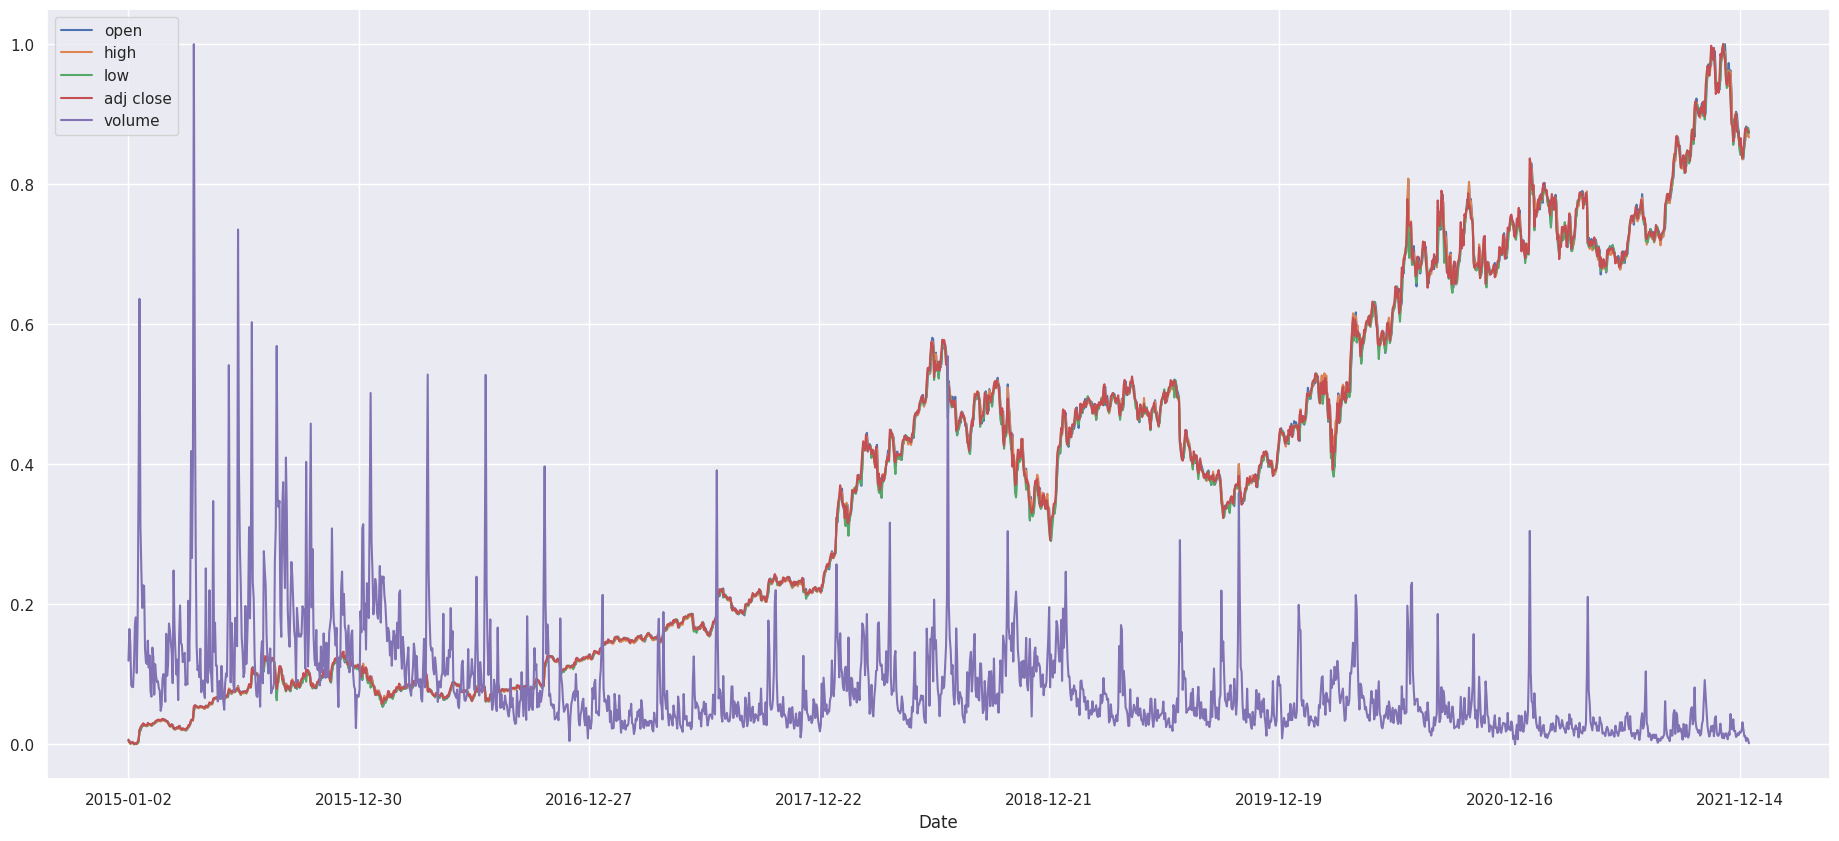

In [ ]:
def normalize_data(df):
    min_max_scaler = preprocessing.MinMaxScaler()
    df['open'] = min_max_scaler.fit_transform(df.open.values.reshape(-1,1))
    df['high'] = min_max_scaler.fit_transform(df.high.values.reshape(-1,1))
    df['low'] = min_max_scaler.fit_transform(df.low.values.reshape(-1,1))
    df['volume'] = min_max_scaler.fit_transform(df.volume.values.reshape(-1,1))
    df['adj close'] = min_max_scaler.fit_transform(df['adj close'].values.reshape(-1,1))
    return df
df = normalize_data(df)
df.plot(figsize=(23,10))
plt.show()

Remove column, load stock data with windowing.

In [ ]:
del df['volume']
def load_data(stock, window):
    data = stock.to_numpy()
    result = []

    for index in range(len(data) - window): # maxmimum date = lastest date - sequence length
        result.append(data[index: index + window]) # index : index + n days

    result = np.array(result).reshape(4*window, -1)
    row = round(0.9 * result.shape[1]) # 90% split

    x_train = result[:, :int(row)]
    y_train = data[window:window+int(row),3].reshape(-1, 1)

    x_test = result[:, int(row):]
    y_test = data[window+int(row):,3].reshape(-1, 1)
    return [x_train, y_train, x_test, y_test]

TRaining and Testing Data

Criação da REde Neural

In [ ]:
model = models.Sequential()
model.add(layers.Dense(10, activation='relu', input_shape=(40,)))
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 10)                  │             410 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │             110 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 10)                  │             110 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              11 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 641 (2.50 KB)

 Trainable params: 641 (2.50 KB)

 Non-trainable params: 0 (0.00 B)

Treinar modelos com dados

Modelo Sequential com os Layers conv1d e flatten

In [ ]:
stock = df.iloc[:1760,:]
window = 10
data = stock.to_numpy()
result = []

for index in range(len(data) - window): # maxmimum date = lastest date - sequence length
    result.append(data[index: index + window]) # index : index + n days

result = np.array(result).reshape(4*window, -1)
x = result.T
y = data[window:,3]
print(x.shape)
print(y.shape)

(1750, 40)
(1750,)


In [ ]:
x = x.reshape(x.shape[0], x.shape[1], 1)
print(x.shape)
(1750, 40, 1)

(1750, 40, 1)


(1750, 40, 1)

In [ ]:
x_train_cnn, x_test_cnn, y_train_cnn, y_test_cnn=train_test_split(x, y, test_size=0.1)
print(x_train_cnn.shape)
print(x_test_cnn.shape)
print(y_train_cnn.shape)
print(y_test_cnn.shape)

(1575, 40, 1)
(175, 40, 1)
(1575,)
(175,)


In [ ]:
model = Sequential()
model.add(Conv1D(32, 2, activation="relu", input_shape=(40, 1)))
model.add(Flatten())
model.add(Dense(64, activation="relu"))
model.add(Dense(1))
model.summary()
model.compile(loss="mse", optimizer="adam")

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 39, 32)              │              96 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 1248)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 64)                  │          79,936 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 80,097 (312.88 KB)

 Trainable params: 80,097 (312.88 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
hist = model.fit(x_train_cnn, y_train_cnn, batch_size=12,epochs=200, validation_data=(x_test_cnn, y_test_cnn))

Epoch 1/200
132/132 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 0.0407 - val_loss: 0.0078
Epoch 2/200
132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0084 - val_loss: 0.0071
Epoch 3/200
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0073 - val_loss: 0.0051
Epoch 4/200
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0058 - val_loss: 0.0045
Epoch 5/200
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0065 - val_loss: 0.0053
Epoch 6/200
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0054 - val_loss: 0.0043
Epoch 7/200
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0052 - val_loss: 0.0043
Epoch 8/200
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0048 - val_loss: 0.0074
Epoch 9/200
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0050 - val_loss: 0.0040
Epoch 10/200
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0049 - val_loss: 0.0037
Epoch 11/200
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0041 - val_loss: 0.0069
Epoch 12/200
132/132 ━━━━━━━━━━━━━━━━━━━

In [ ]:
y_pred_cnn = model.predict(x_test_cnn)

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step


50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0019
0.0020106590818613768
MSE: 0.0020


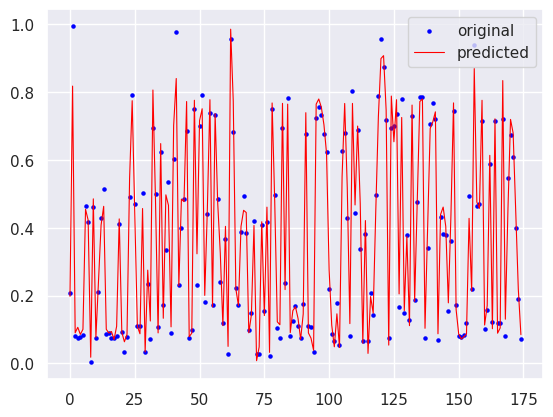

In [ ]:
print(model.evaluate(x_train_cnn, y_train_cnn))

print("MSE: %.4f" % mean_squared_error(y_test_cnn, y_pred_cnn))
x_ax = range(len(y_pred_cnn))
plt.scatter(x_ax, y_test_cnn, s=5, color="blue", label="original")
plt.plot(x_ax, y_pred_cnn, lw=0.8, color="red", label="predicted")
plt.legend()
plt.show()

## Análise de Sentimentos

In [ ]:
noticias = pd.read_csv("https://raw.githubusercontent.com/adriel1ft/stock-prediction-cnn/main/articles_netflix_2015-2022.csv", index_col = 0)


In [ ]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer, pipeline

finbert = AutoModelForSequenceClassification.from_pretrained("yiyanghkust/finbert-tone", num_labels=3)
tokenizer = AutoTokenizer.from_pretrained("yiyanghkust/finbert-tone")

sentiment_pipeline = pipeline("sentiment-analysis", model=finbert, tokenizer=tokenizer)

data = noticias['title'].tolist()

resultados = sentiment_pipeline(data)

noticias['sentimento'] = [resultado['label'] for resultado in resultados]
noticias['score'] = [resultado['score'] for resultado in resultados]

print(noticias)

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


                                                        title sentimento  \
year_month                                                                 
201501      Sundance 2015: Duplass Brothers, Netflix Make ...    Neutral   
201501      Netflix Accelerates Ambitious Global Expansion...   Positive   
201501       Movie Studio by Amazon for Screens Big and Small    Neutral   
201501      As Content Pours From Everywhere, New Network ...    Neutral   
201501                    Cleaning Up the Mac’s Printers List    Neutral   
...                                                       ...        ...   
202112      The Best Movies and TV Shows New to Netflix, A...   Positive   
202112                            5 Things to Do This Weekend    Neutral   
202112       ‘Emily in Paris’ and the City I Thought Was Mine    Neutral   
202112      ‘Cowboy Bebop’ Beats and the Universe of ‘Dune...    Neutral   
202112          In 2021, Black Boyhood Got More Complex on TV    Neutral   

           

In [ ]:
noticias.head()

,title,sentimento,score
year_month,,,
201501,"Sundance 2015: Duplass Brothers, Netflix Make ...",Neutral,0.999860
201501,Netflix Accelerates Ambitious Global Expansion...,Positive,0.995587
201501,Movie Studio by Amazon for Screens Big and Small,Neutral,0.999978
201501,"As Content Pours From Everywhere, New Network ...",Neutral,0.894186
201501,Cleaning Up the Mac’s Printers List,Neutral,0.999932


In [ ]:
noticias['year_month'] = pd.to_datetime(noticias['year_month'])

noticias_monthly_avg = noticias.groupby(noticias['year_month'].dt.to_period('M')).agg({
    'score': 'mean',
    'sentimento': lambda x: x.mode()[0]  # Sentimento mais frequente
}).reset_index()

noticias_monthly_avg.rename(columns={'year_month': 'month'}, inplace=True)

print(noticias_monthly_avg)

      month     score sentimento
0   2015-01  0.978255    Neutral
1   2015-02  0.993725    Neutral
2   2015-03  0.947350    Neutral
3   2015-04  0.999888    Neutral
4   2015-05  0.999075    Neutral
..      ...       ...        ...
79  2021-08  0.967460    Neutral
80  2021-09  0.999810    Neutral
81  2021-10  0.977608    Neutral
82  2021-11  0.993130    Neutral
83  2021-12  0.999786    Neutral

[84 rows x 3 columns]


In [ ]:
noticias_monthly_avg['sentimento'].unique()

array(['Neutral'], dtype=object)

In [ ]:
"""noticias.reset_index(inplace=True)

noticias['year_month'] = pd.to_datetime(noticias['year_month'], format='%Y%m')

noticias_monthly_avg = noticias.groupby(noticias['year_month'].dt.to_period('M'))['score'].mean().reset_index()

print(noticias_monthly_avg)
"""

   year_month     score
0     2015-01  0.978255
1     2015-02  0.993725
2     2015-03  0.947350
3     2015-04  0.999888
4     2015-05  0.999075
..        ...       ...
79    2021-08  0.967460
80    2021-09  0.999810
81    2021-10  0.977608
82    2021-11  0.993130
83    2021-12  0.999786

[84 rows x 2 columns]


In [ ]:
csv_file = 'avg_monthly_sentiment_scores_netflix.csv'

noticias_monthly_avg.to_csv(csv_file, index=False)

print(f"Dados armazenados em {csv_file} com sucesso.")


Dados armazenados em avg_monthly_sentiment_scores_netflix.csv com sucesso.
